# Week 9: Deep Learning Fundamentals for Quantitative Finance

## 🎯 Learning Objectives

By the end of this week, you will understand:
- **Neural Network Basics**: Architecture, activation functions, loss functions
- **Backpropagation**: How neural networks learn
- **PyTorch Fundamentals**: Tensors, autograd, model building
- **Regularization**: Dropout, batch normalization, early stopping
- **Sequence Models**: RNNs and LSTMs for time series
- **Applications**: Stock prediction, volatility forecasting

---

## Why Deep Learning for Finance?

Deep learning excels at:
1. **Finding non-linear patterns** traditional models miss
2. **Handling high-dimensional data** (many features)
3. **Learning feature representations** automatically
4. **Modeling sequential dependencies** (time series)

### ⚠️ Challenges in Finance:
- Low signal-to-noise ratio
- Non-stationarity (market regimes change)
- Overfitting risk is HIGH
- Need careful validation (walk-forward)

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("✅ Libraries loaded successfully!")
print(f"📚 Week 9: Deep Learning Fundamentals")
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"💻 Device: {device}")

✅ Libraries loaded successfully!
📚 Week 9: Deep Learning Fundamentals
🔧 PyTorch version: 2.9.1
💻 Device: cpu


---

# Part 1: Neural Network Fundamentals

## The Perceptron (Single Neuron)

A single neuron computes:

$$y = f\left(\sum_{i=1}^{n} w_i x_i + b\right) = f(\mathbf{w}^T\mathbf{x} + b)$$

Where:
- $\mathbf{x}$ = input features
- $\mathbf{w}$ = weights (learned parameters)
- $b$ = bias (learned)
- $f$ = activation function

## Activation Functions

| Function | Formula | Range | Use Case |
|----------|---------|-------|----------|
| **Sigmoid** | $\sigma(x) = \frac{1}{1+e^{-x}}$ | (0, 1) | Binary classification output |
| **Tanh** | $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ | (-1, 1) | Hidden layers (centered) |
| **ReLU** | $\max(0, x)$ | [0, ∞) | Hidden layers (most common) |
| **Leaky ReLU** | $\max(0.01x, x)$ | (-∞, ∞) | Avoids "dying ReLU" |
| **Softmax** | $\frac{e^{x_i}}{\sum_j e^{x_j}}$ | (0, 1), sum=1 | Multi-class output |

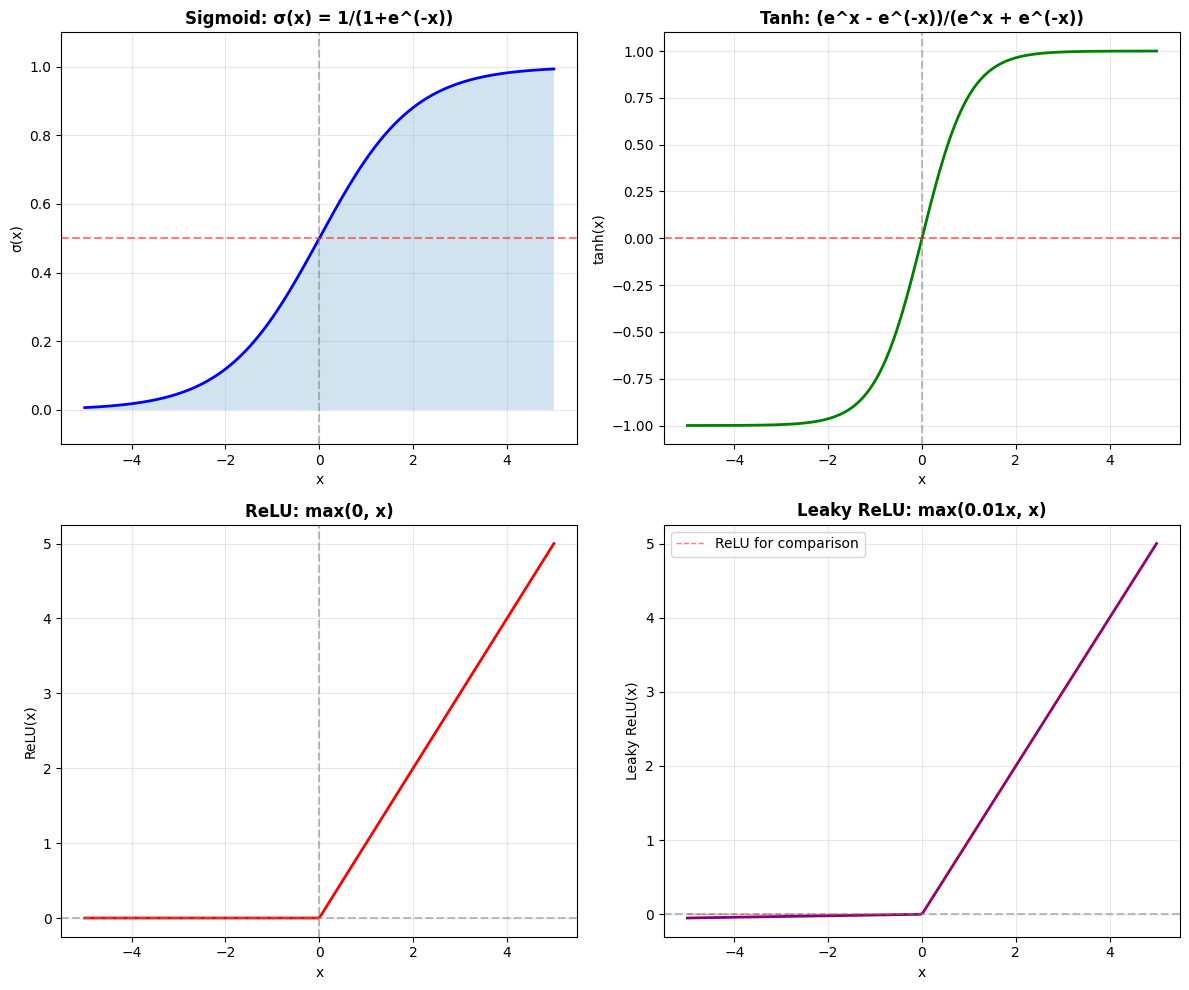


📊 OUTPUT EXPLANATION:
• Sigmoid: Squashes to (0,1) - good for probabilities
• Tanh: Zero-centered (-1,1) - often better than sigmoid
• ReLU: Fast, sparse - most popular for hidden layers
• Leaky ReLU: Prevents 'dead neurons' when x < 0

⚠️  Sigmoid/Tanh suffer from 'vanishing gradients' in deep nets!


In [3]:
# Visualize activation functions
x = np.linspace(-5, 5, 200)

# Activation functions
sigmoid = 1 / (1 + np.exp(-x))
tanh_act = np.tanh(x)
relu = np.maximum(0, x)
leaky_relu = np.where(x > 0, x, 0.01 * x)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Sigmoid
axes[0, 0].plot(x, sigmoid, 'b-', linewidth=2)
axes[0, 0].axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
axes[0, 0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Sigmoid: σ(x) = 1/(1+e^(-x))', fontweight='bold')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('σ(x)')
axes[0, 0].set_ylim(-0.1, 1.1)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].fill_between(x, 0, sigmoid, alpha=0.2)

# Tanh
axes[0, 1].plot(x, tanh_act, 'g-', linewidth=2)
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 1].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Tanh: (e^x - e^(-x))/(e^x + e^(-x))', fontweight='bold')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('tanh(x)')
axes[0, 1].grid(True, alpha=0.3)

# ReLU
axes[1, 0].plot(x, relu, 'r-', linewidth=2)
axes[1, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].set_title('ReLU: max(0, x)', fontweight='bold')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('ReLU(x)')
axes[1, 0].grid(True, alpha=0.3)

# Leaky ReLU
axes[1, 1].plot(x, leaky_relu, 'purple', linewidth=2)
axes[1, 1].plot(x, relu, 'r--', linewidth=1, alpha=0.5, label='ReLU for comparison')
axes[1, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Leaky ReLU: max(0.01x, x)', fontweight='bold')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('Leaky ReLU(x)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 OUTPUT EXPLANATION:")
print("="*60)
print("• Sigmoid: Squashes to (0,1) - good for probabilities")
print("• Tanh: Zero-centered (-1,1) - often better than sigmoid")
print("• ReLU: Fast, sparse - most popular for hidden layers")
print("• Leaky ReLU: Prevents 'dead neurons' when x < 0")
print("\n⚠️  Sigmoid/Tanh suffer from 'vanishing gradients' in deep nets!")

---

## Multi-Layer Perceptron (MLP)

Stack multiple layers of neurons:

$$\mathbf{h}^{(1)} = f^{(1)}(\mathbf{W}^{(1)}\mathbf{x} + \mathbf{b}^{(1)})$$
$$\mathbf{h}^{(2)} = f^{(2)}(\mathbf{W}^{(2)}\mathbf{h}^{(1)} + \mathbf{b}^{(2)})$$
$$\hat{y} = f^{(out)}(\mathbf{W}^{(out)}\mathbf{h}^{(2)} + \mathbf{b}^{(out)})$$

## Loss Functions

| Task | Loss Function | Formula |
|------|--------------|--------|
| **Regression** | MSE | $\frac{1}{n}\sum(y - \hat{y})^2$ |
| **Binary Classification** | Binary Cross-Entropy | $-[y\log(\hat{y}) + (1-y)\log(1-\hat{y})]$ |
| **Multi-class** | Cross-Entropy | $-\sum_c y_c \log(\hat{y}_c)$ |

In [4]:
# Build a simple MLP in PyTorch
class SimpleMLP(nn.Module):
    """
    A simple Multi-Layer Perceptron for binary classification.
    
    Architecture:
    Input -> Hidden1 (64) -> ReLU -> Hidden2 (32) -> ReLU -> Output (1) -> Sigmoid
    """
    def __init__(self, input_dim, hidden_dims=[64, 32]):
        super(SimpleMLP, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, hidden_dims[0])
        self.layer2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.output = nn.Linear(hidden_dims[1], 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Forward pass through network
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

# Create model and show architecture
model = SimpleMLP(input_dim=10)

print("MODEL ARCHITECTURE")
print("="*60)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Parameter Count:")
print(f"   Layer 1: 10 inputs × 64 neurons + 64 biases = {10*64 + 64}")
print(f"   Layer 2: 64 × 32 + 32 = {64*32 + 32}")
print(f"   Output:  32 × 1 + 1 = {32*1 + 1}")
print(f"   ─────────────────────────")
print(f"   Total: {total_params:,} parameters")

MODEL ARCHITECTURE
SimpleMLP(
  (layer1): Linear(in_features=10, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

📊 Parameter Count:
   Layer 1: 10 inputs × 64 neurons + 64 biases = 704
   Layer 2: 64 × 32 + 32 = 2080
   Output:  32 × 1 + 1 = 33
   ─────────────────────────
   Total: 2,817 parameters


---

# Part 2: Backpropagation & Gradient Descent

## The Training Loop

1. **Forward Pass**: Compute predictions
2. **Compute Loss**: Compare predictions to true values
3. **Backward Pass**: Compute gradients via chain rule
4. **Update Weights**: $\mathbf{w} \leftarrow \mathbf{w} - \alpha \nabla L$

## Gradient Descent Variants

| Optimizer | Update Rule | Notes |
|-----------|-------------|-------|
| **SGD** | $w = w - \alpha \nabla L$ | Basic, can be slow |
| **Momentum** | $v = \beta v + \nabla L; w = w - \alpha v$ | Accelerates convergence |
| **Adam** | Adaptive learning rates | Most popular, good default |

In [5]:
# Generate synthetic financial data
np.random.seed(42)
n_samples = 2000

# Features: momentum, volatility, volume, etc.
X = np.random.randn(n_samples, 10)

# Target: Binary classification (up/down)
# Non-linear relationship
true_weights = np.array([0.5, -0.3, 0.4, 0.2, -0.1, 0.3, -0.2, 0.1, 0.4, -0.3])
linear_part = X @ true_weights
# Add non-linearity
prob = 1 / (1 + np.exp(-(linear_part + 0.3*X[:, 0]*X[:, 1] - 0.2*X[:, 2]**2)))
y = (prob > 0.5).astype(float) + np.random.randn(n_samples) * 0.1
y = (y > 0.5).astype(float)

# Split data (time-series aware - no shuffle!)
split_idx = int(0.8 * n_samples)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train).unsqueeze(1)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"📊 Dataset Created:")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Class balance (train): {y_train.mean():.2%} positive")

📊 Dataset Created:
   Training samples: 1600
   Test samples: 400
   Features: 10
   Class balance (train): 43.75% positive


In [6]:
# Training function
def train_model(model, train_loader, X_test_t, y_test_t, epochs=100, lr=0.001):
    """
    Train a PyTorch model with logging.
    
    Returns history of losses and accuracies.
    """
    criterion = nn.BCELoss()  # Binary Cross-Entropy
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for X_batch, y_batch in train_loader:
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass
            optimizer.zero_grad()  # Clear previous gradients
            loss.backward()        # Compute gradients
            optimizer.step()       # Update weights
            
            epoch_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_t)
            test_loss = criterion(test_outputs, y_test_t).item()
            test_pred = (test_outputs > 0.5).float()
            test_acc = (test_pred == y_test_t).float().mean().item()
        
        train_loss = epoch_loss / len(train_loader)
        train_acc = correct / total
        
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | "
                  f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
    
    return history

# Train the model
print("TRAINING MODEL")
print("="*80)
model = SimpleMLP(input_dim=10)
history = train_model(model, train_loader, X_test_t, y_test_t, epochs=100, lr=0.001)

TRAINING MODEL
Epoch  20 | Train Loss: 0.0384 | Test Loss: 0.1082 | Train Acc: 0.9906 | Test Acc: 0.9475
Epoch  40 | Train Loss: 0.0113 | Test Loss: 0.1212 | Train Acc: 1.0000 | Test Acc: 0.9525
Epoch  60 | Train Loss: 0.0034 | Test Loss: 0.1317 | Train Acc: 1.0000 | Test Acc: 0.9525
Epoch  80 | Train Loss: 0.0013 | Test Loss: 0.1472 | Train Acc: 1.0000 | Test Acc: 0.9475
Epoch 100 | Train Loss: 0.0005 | Test Loss: 0.1607 | Train Acc: 1.0000 | Test Acc: 0.9575


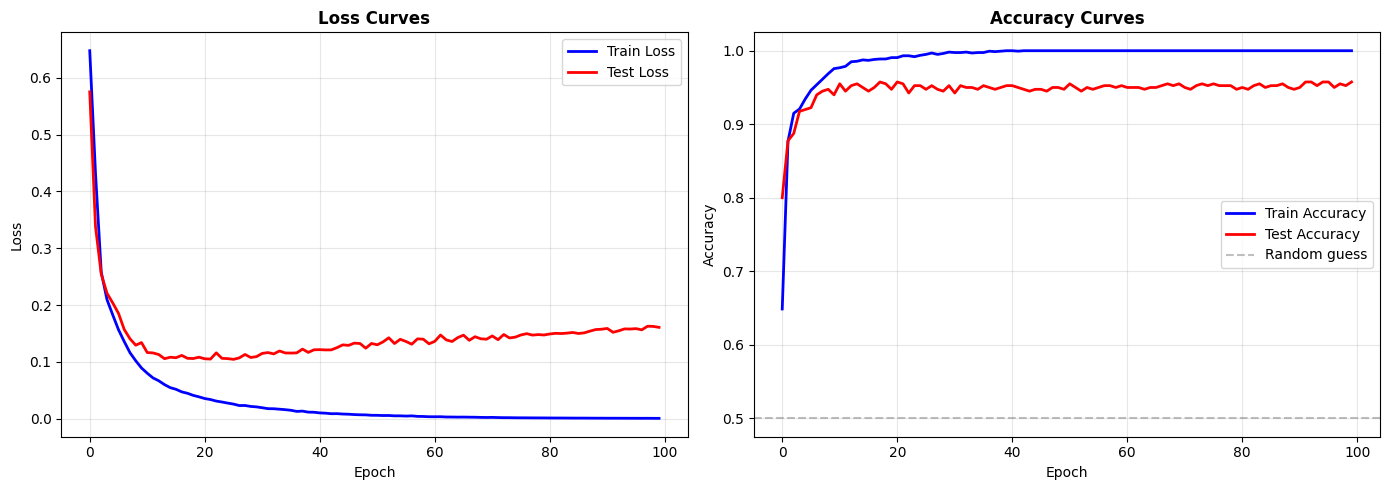


📊 OUTPUT EXPLANATION:
• Loss should decrease as model learns
• Train < Test loss is expected (seen vs unseen data)
• Large gap = OVERFITTING (memorizing train data)
• If test loss increases while train decreases → Stop training!

🎯 Final Test Accuracy: 95.75%


In [7]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(history['test_loss'], 'r-', label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curves', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
axes[1].plot(history['test_acc'], 'r-', label='Test Accuracy', linewidth=2)
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random guess')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Curves', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 OUTPUT EXPLANATION:")
print("="*60)
print("• Loss should decrease as model learns")
print("• Train < Test loss is expected (seen vs unseen data)")
print("• Large gap = OVERFITTING (memorizing train data)")
print("• If test loss increases while train decreases → Stop training!")
print(f"\n🎯 Final Test Accuracy: {history['test_acc'][-1]:.2%}")

---

# Part 3: Regularization Techniques

## Why Regularization?

Deep networks have MANY parameters → High risk of overfitting!

## Common Techniques

| Technique | Description | When to Use |
|-----------|-------------|-------------|
| **L2 Regularization** | Add $\lambda \|\mathbf{w}\|^2$ to loss | Always (weight decay in Adam) |
| **Dropout** | Randomly zero neurons during training | Hidden layers |
| **Batch Normalization** | Normalize layer inputs | Stabilizes training |
| **Early Stopping** | Stop when validation loss increases | Always use! |

In [8]:
# Improved model with regularization
class RegularizedMLP(nn.Module):
    """
    MLP with Dropout and Batch Normalization.
    """
    def __init__(self, input_dim, hidden_dims=[64, 32], dropout_rate=0.3):
        super(RegularizedMLP, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])  # Batch Normalization
        self.dropout1 = nn.Dropout(dropout_rate)    # Dropout
        
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.output = nn.Linear(hidden_dims[1], 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = torch.sigmoid(self.output(x))
        return x

# Train with early stopping
def train_with_early_stopping(model, train_loader, X_test_t, y_test_t, 
                              epochs=200, lr=0.001, patience=20):
    """
    Train with early stopping when validation loss stops improving.
    """
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # L2 regularization
    
    best_loss = float('inf')
    patience_counter = 0
    best_weights = None
    history = {'train_loss': [], 'test_loss': []}
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_t)
            test_loss = criterion(test_outputs, y_test_t).item()
        
        train_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        
        # Early stopping check
        if test_loss < best_loss:
            best_loss = test_loss
            best_weights = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"\n⚠️  Early stopping at epoch {epoch+1}!")
            model.load_state_dict(best_weights)  # Restore best weights
            break
            
        if (epoch + 1) % 25 == 0:
            print(f"Epoch {epoch+1:3d} | Train: {train_loss:.4f} | Test: {test_loss:.4f} | Patience: {patience_counter}")
    
    return history, epoch + 1

# Train regularized model
print("TRAINING REGULARIZED MODEL")
print("="*80)
reg_model = RegularizedMLP(input_dim=10, dropout_rate=0.3)
reg_history, final_epoch = train_with_early_stopping(
    reg_model, train_loader, X_test_t, y_test_t, 
    epochs=200, lr=0.001, patience=20
)

TRAINING REGULARIZED MODEL
Epoch  25 | Train: 0.1730 | Test: 0.1459 | Patience: 1
Epoch  50 | Train: 0.1715 | Test: 0.1308 | Patience: 7

⚠️  Early stopping at epoch 63!


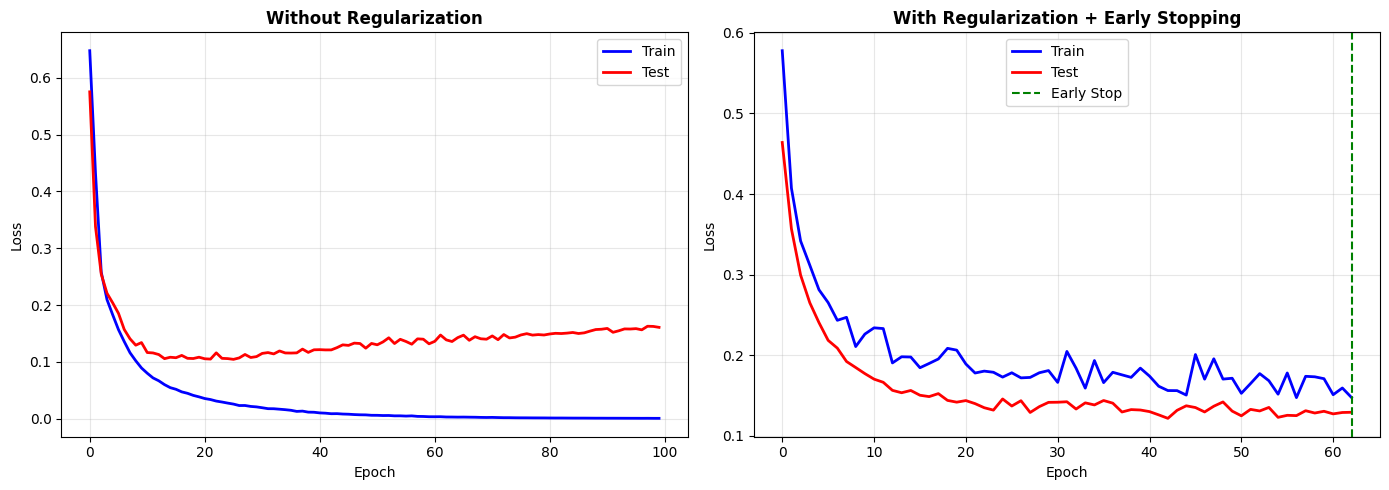


📊 REGULARIZATION COMPARISON:
Metric                               No Reg     With Reg
------------------------------------------------------------
Final Train Loss                     0.0005       0.1476
Final Test Loss                      0.1607       0.1293
Gap (Train-Test)                    -0.1601       0.0183
Epochs Trained                          100           63


In [9]:
# Compare regularized vs non-regularized
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original model
axes[0].plot(history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0].plot(history['test_loss'], 'r-', label='Test', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Without Regularization', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Regularized model
axes[1].plot(reg_history['train_loss'], 'b-', label='Train', linewidth=2)
axes[1].plot(reg_history['test_loss'], 'r-', label='Test', linewidth=2)
axes[1].axvline(x=final_epoch-1, color='green', linestyle='--', label='Early Stop')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('With Regularization + Early Stopping', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final comparison
print("\n📊 REGULARIZATION COMPARISON:")
print("="*60)
print(f"{'Metric':<30} {'No Reg':>12} {'With Reg':>12}")
print("-"*60)
print(f"{'Final Train Loss':<30} {history['train_loss'][-1]:>12.4f} {reg_history['train_loss'][-1]:>12.4f}")
print(f"{'Final Test Loss':<30} {history['test_loss'][-1]:>12.4f} {reg_history['test_loss'][-1]:>12.4f}")
print(f"{'Gap (Train-Test)':<30} {history['train_loss'][-1]-history['test_loss'][-1]:>12.4f} {reg_history['train_loss'][-1]-reg_history['test_loss'][-1]:>12.4f}")
print(f"{'Epochs Trained':<30} {100:>12d} {final_epoch:>12d}")

---

# Part 4: Recurrent Neural Networks (RNNs) for Time Series

## Why RNNs?

Financial data has **sequential dependencies** - today's price relates to yesterday's!

## RNN Architecture

$$\mathbf{h}_t = \tanh(\mathbf{W}_{hh}\mathbf{h}_{t-1} + \mathbf{W}_{xh}\mathbf{x}_t + \mathbf{b}_h)$$
$$\mathbf{y}_t = \mathbf{W}_{hy}\mathbf{h}_t + \mathbf{b}_y$$

The hidden state $\mathbf{h}_t$ carries information from previous timesteps.

## LSTM (Long Short-Term Memory)

Solves the **vanishing gradient problem** with gates:

- **Forget Gate**: What to discard from memory
- **Input Gate**: What new info to store
- **Output Gate**: What to output from memory

$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$ (forget gate)
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$ (input gate)
$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$ (output gate)

In [15]:
# Create sequence data for LSTM
def create_sequences(data, seq_length):
    """
    Convert time series to sequences for LSTM.
    
    Input: [1, 2, 3, 4, 5], seq_length=3
    Output: X = [[1,2,3], [2,3,4]], y = [4, 5]
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Generate synthetic price data
np.random.seed(42)
n = 1000

# Simulate stock returns with some autocorrelation
returns = np.zeros(n)
for t in range(1, n):
    returns[t] = 0.1 * returns[t-1] + np.random.randn() * 0.02

# Create sequences
seq_length = 20
X_seq, y_seq = create_sequences(returns, seq_length)

# Split (time-series aware)
split = int(0.8 * len(X_seq))
X_train_seq = X_seq[:split]
X_test_seq = X_seq[split:]
y_train_seq = y_seq[:split]
y_test_seq = y_seq[split:]

# Convert to PyTorch tensors
# LSTM expects (batch, seq_length, features)
X_train_lstm = torch.FloatTensor(X_train_seq).unsqueeze(-1)  # Add feature dimension
X_test_lstm = torch.FloatTensor(X_test_seq).unsqueeze(-1)
y_train_lstm = torch.FloatTensor(y_train_seq).unsqueeze(-1)
y_test_lstm = torch.FloatTensor(y_test_seq).unsqueeze(-1)

print(f"📊 LSTM Data Shape:")
print(f"   X_train: {X_train_lstm.shape} (samples, sequence, features)")
print(f"   y_train: {y_train_lstm.shape}")
print(f"   Sequence length: {seq_length} days")

📊 LSTM Data Shape:
   X_train: torch.Size([784, 20, 1]) (samples, sequence, features)
   y_train: torch.Size([784, 1])
   Sequence length: 20 days


In [16]:
# LSTM Model
class LSTMPredictor(nn.Module):
    """
    LSTM for time series prediction.
    """
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMPredictor, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # x shape: (batch, seq_length, features)
        lstm_out, (h_n, c_n) = self.lstm(x)
        # Take the last hidden state
        last_hidden = lstm_out[:, -1, :]
        out = self.fc(last_hidden)
        return out

# Create and train LSTM
lstm_model = LSTMPredictor(input_size=1, hidden_size=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Training
print("TRAINING LSTM")
print("="*60)

train_dataset = TensorDataset(X_train_lstm, y_train_lstm)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # Don't shuffle time series!

lstm_history = {'train_loss': [], 'test_loss': []}

for epoch in range(50):
    lstm_model.train()
    epoch_loss = 0
    
    for X_batch, y_batch in train_loader:
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    lstm_model.eval()
    with torch.no_grad():
        test_pred = lstm_model(X_test_lstm)
        test_loss = criterion(test_pred, y_test_lstm).item()
    
    train_loss = epoch_loss / len(train_loader)
    lstm_history['train_loss'].append(train_loss)
    lstm_history['test_loss'].append(test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d} | Train MSE: {train_loss:.6f} | Test MSE: {test_loss:.6f}")

TRAINING LSTM
Epoch  10 | Train MSE: 0.000396 | Test MSE: 0.000376
Epoch  20 | Train MSE: 0.000394 | Test MSE: 0.000375
Epoch  30 | Train MSE: 0.000390 | Test MSE: 0.000375
Epoch  40 | Train MSE: 0.000391 | Test MSE: 0.000376
Epoch  50 | Train MSE: 0.000389 | Test MSE: 0.000376


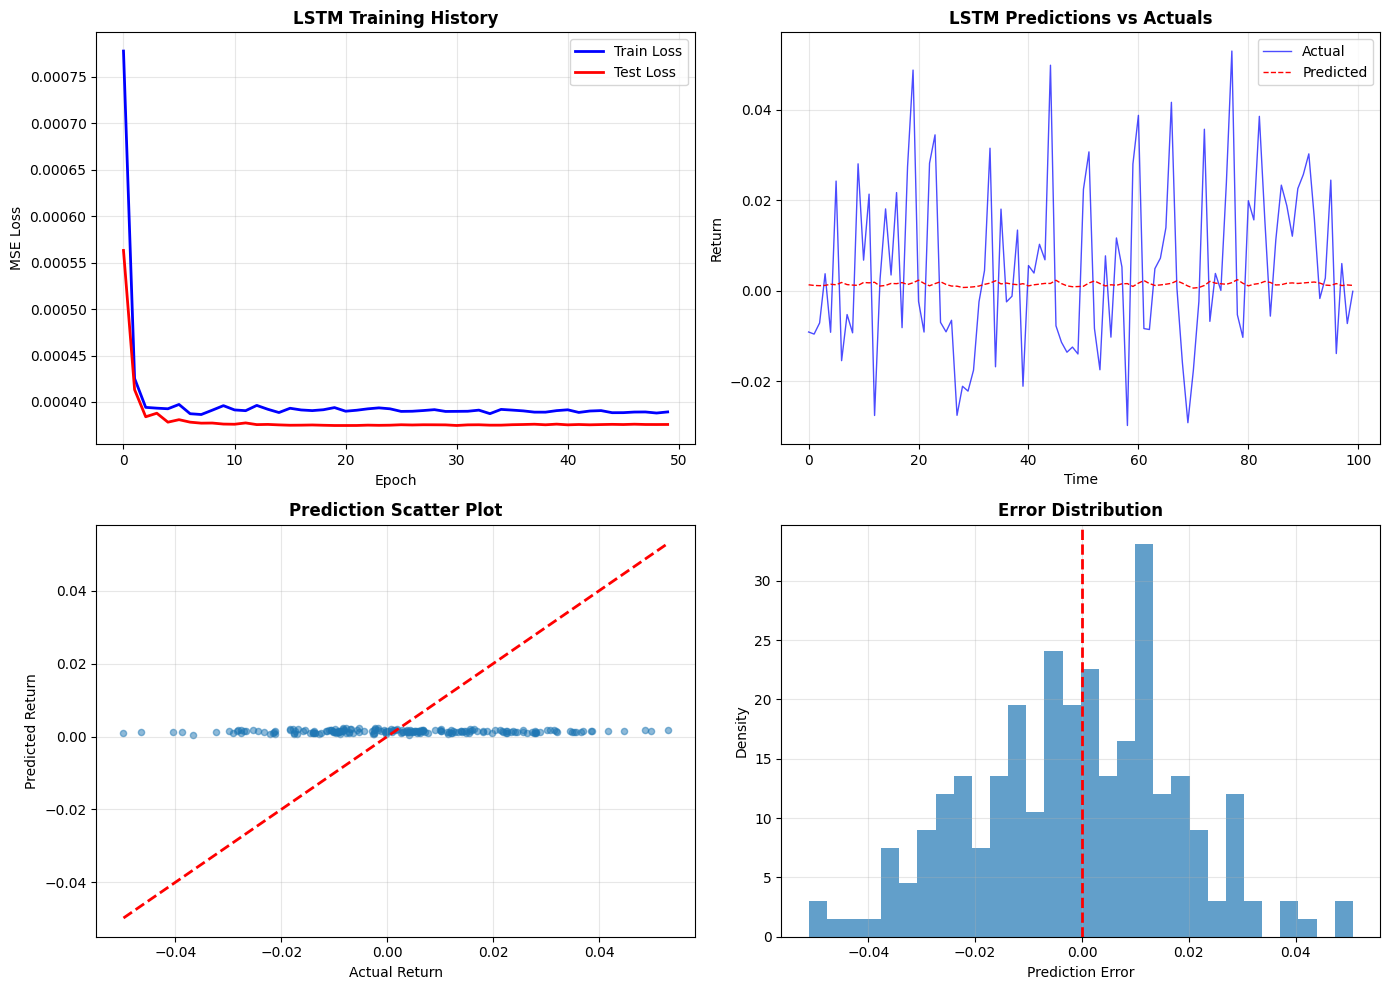


📊 LSTM PERFORMANCE METRICS:
MSE: 0.000376
RMSE: 0.019385
Correlation: 0.0893
Direction Accuracy: 54.59%

💡 In finance, direction accuracy > 52% can be profitable!


In [17]:
# Evaluate LSTM predictions
lstm_model.eval()
with torch.no_grad():
    predictions = lstm_model(X_test_lstm).numpy().flatten()

actuals = y_test_lstm.numpy().flatten()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training history
axes[0, 0].plot(lstm_history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(lstm_history['test_loss'], 'r-', label='Test Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('LSTM Training History', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Predictions vs Actuals
axes[0, 1].plot(actuals[:100], 'b-', label='Actual', linewidth=1, alpha=0.7)
axes[0, 1].plot(predictions[:100], 'r--', label='Predicted', linewidth=1)
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Return')
axes[0, 1].set_title('LSTM Predictions vs Actuals', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Scatter plot
axes[1, 0].scatter(actuals, predictions, alpha=0.5, s=20)
axes[1, 0].plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', linewidth=2)
axes[1, 0].set_xlabel('Actual Return')
axes[1, 0].set_ylabel('Predicted Return')
axes[1, 0].set_title('Prediction Scatter Plot', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Prediction error distribution
errors = predictions - actuals
axes[1, 1].hist(errors, bins=30, density=True, alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Prediction Error')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Error Distribution', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Metrics
correlation = np.corrcoef(actuals, predictions)[0, 1]
mse = np.mean(errors**2)
direction_acc = np.mean((predictions > 0) == (actuals > 0))

print("\n📊 LSTM PERFORMANCE METRICS:")
print("="*60)
print(f"MSE: {mse:.6f}")
print(f"RMSE: {np.sqrt(mse):.6f}")
print(f"Correlation: {correlation:.4f}")
print(f"Direction Accuracy: {direction_acc:.2%}")
print("\n💡 In finance, direction accuracy > 52% can be profitable!")

---

# Summary: Key Concepts

## Neural Network Components

| Component | Purpose | Key Formula |
|-----------|---------|-------------|
| **Linear Layer** | Transform input | $y = Wx + b$ |
| **Activation** | Add non-linearity | ReLU: $\max(0, x)$ |
| **Loss Function** | Measure error | MSE: $(y-\hat{y})^2$ |
| **Optimizer** | Update weights | Adam: adaptive LR |

## Regularization Techniques

- **Dropout**: Randomly zero neurons (p=0.2-0.5)
- **Batch Norm**: Normalize layer inputs
- **L2 Regularization**: Weight decay in optimizer
- **Early Stopping**: Monitor validation loss

## For Time Series

- Use **LSTM** or **GRU** for sequential dependencies
- **Don't shuffle** time series data!
- Walk-forward validation is essential

## Interview Questions

1. **Why ReLU over Sigmoid?** - Avoids vanishing gradients, computationally efficient
2. **What does Dropout do?** - Prevents co-adaptation, acts as ensemble
3. **Why LSTM over simple RNN?** - Better at capturing long-term dependencies
4. **How to prevent overfitting in finance?** - Walk-forward CV, regularization, simple models

In [18]:
# Final summary
print("""
╔══════════════════════════════════════════════════════════════════╗
║           WEEK 9 COMPLETE: DEEP LEARNING FUNDAMENTALS            ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  ✓ Part 1: Neural Network Basics                                ║
║    • Perceptron and activation functions                        ║
║    • MLP architecture                                           ║
║    • Loss functions                                             ║
║                                                                  ║
║  ✓ Part 2: Training Neural Networks                             ║
║    • Backpropagation                                            ║
║    • Gradient descent optimizers                                ║
║    • PyTorch training loop                                      ║
║                                                                  ║
║  ✓ Part 3: Regularization                                       ║
║    • Dropout and Batch Normalization                            ║
║    • L2 regularization                                          ║
║    • Early stopping                                             ║
║                                                                  ║
║  ✓ Part 4: Sequence Models                                      ║
║    • RNN architecture                                           ║
║    • LSTM for time series                                       ║
║    • Return prediction                                          ║
║                                                                  ║
╚══════════════════════════════════════════════════════════════════╝

🎯 Next Week: NLP for Finance!
""")


╔══════════════════════════════════════════════════════════════════╗
║           WEEK 9 COMPLETE: DEEP LEARNING FUNDAMENTALS            ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  ✓ Part 1: Neural Network Basics                                ║
║    • Perceptron and activation functions                        ║
║    • MLP architecture                                           ║
║    • Loss functions                                             ║
║                                                                  ║
║  ✓ Part 2: Training Neural Networks                             ║
║    • Backpropagation                                            ║
║    • Gradient descent optimizers                                ║
║    • PyTorch training loop                                      ║
║                                                                  ║
║  ✓ Part 3: Regularization              